In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import FeatureUnion
from sklearn.impute import SimpleImputer

# Bureau

All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).

In [5]:
#bureau = pd.read_csv('C:\\Users\\maria\\Desktop\\Uni\\S2\\Machine Learning\\Group Project\\data\\bureau.csv')
bureau = pd.read_csv('../all/bureau.csv')

In [6]:
bureau.shape

(1716428, 17)

In [7]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [8]:
#number of unique SK_ID_CURR
len(bureau['SK_ID_CURR'].unique())

305811

In [9]:
bureau.groupby(['SK_ID_CURR'])['SK_ID_CURR'].count().sort_values(ascending=False)

SK_ID_CURR
120860    116
169704     94
318065     78
251643     61
425396     60
         ... 
243209      1
397571      1
192555      1
325740      1
154408      1
Name: SK_ID_CURR, Length: 305811, dtype: int64

In [10]:
variables_type = pd.DataFrame(bureau.dtypes)

cat_variables = list(variables_type[variables_type[0] == "object"].index)

int_variables = list(variables_type[variables_type[0] == "int64"].index)

float_variables = list(variables_type[variables_type[0] == "float64"].index)

cat_binary_variables = []
for i in bureau:
    if ((list(bureau[i].unique()) == [0,1]) or (list(bureau[i].unique()) == [1,0])) and (i != "TARGET"):
        cat_binary_variables.append(i)

int_with_no_binary = [j for j in int_variables if j not in cat_binary_variables and j not in ["SK_ID_CURR", "SK_ID_BUREAU"]]

num_variables = int_with_no_binary + float_variables

print("Categorical variables (non-binary coded):", cat_variables)
print("Categorical variables (binary):", cat_binary_variables)
print("Numerical variables:", num_variables)

Categorical variables (non-binary coded): ['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']
Categorical variables (binary): []
Numerical variables: ['DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'CNT_CREDIT_PROLONG', 'DAYS_CREDIT_UPDATE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'AMT_ANNUITY']


In [11]:
for column in cat_variables:
    print(column)
    print(bureau[column].unique())
    print('--------------------------')

CREDIT_ACTIVE
['Closed' 'Active' 'Sold' 'Bad debt']
--------------------------
CREDIT_CURRENCY
['currency 1' 'currency 2' 'currency 4' 'currency 3']
--------------------------
CREDIT_TYPE
['Consumer credit' 'Credit card' 'Mortgage' 'Car loan' 'Microloan'
 'Loan for working capital replenishment' 'Loan for business development'
 'Real estate loan' 'Unknown type of loan' 'Another type of loan'
 'Cash loan (non-earmarked)' 'Loan for the purchase of equipment'
 'Mobile operator loan' 'Interbank credit'
 'Loan for purchase of shares (margin lending)']
--------------------------


**Duplicates**

In [12]:
#check duplicates
duplicate_rows = bureau[bureau.duplicated()]
print('Number of duplicate rows:', len(duplicate_rows))

Number of duplicate rows: 0


**Missing Values**

In [13]:
#List the variables with missing values higher or equal to 40% to exclude these variables later on
#List the variables with missing values higher than 0% and lower than 40% to preprocess them later on
miss_lower40 = []
miss_higher40 = []

for i in bureau:
    pct_missing = (bureau[i].isna().sum()/len(bureau[i]))*100
    if pct_missing > 0 and pct_missing < 40:
        miss_lower40.append(i)
    if pct_missing >= 40:
        miss_higher40.append(i)

In [14]:
#Exclude the variables with missing values higher or equal to 40%
if (len(miss_lower40) != 0) | (len(miss_higher40) != 0):
    cat_variables = [i for i in cat_variables if i not in miss_higher40]
    num_variables = [i for i in num_variables if i not in miss_higher40]

**Statistics**

In [15]:
bureau[num_variables].describe()

,DAYS_CREDIT,CREDIT_DAY_OVERDUE,CNT_CREDIT_PROLONG,DAYS_CREDIT_UPDATE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE
count,1.716428e+06,1.716428e+06,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06
mean,-1.142108e+03,8.181666e-01,6.410406e-03,-5.937483e+02,5.105174e+02,-1.017437e+03,3.549946e+05,1.370851e+05,6.229515e+03,3.791276e+01
std,7.951649e+02,3.654443e+01,9.622391e-02,7.207473e+02,4.994220e+03,7.140106e+02,1.149811e+06,6.774011e+05,4.503203e+04,5.937650e+03
min,-2.922000e+03,0.000000e+00,0.000000e+00,-4.194700e+04,-4.206000e+04,-4.202300e+04,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00
25%,-1.666000e+03,0.000000e+00,0.000000e+00,-9.080000e+02,-1.138000e+03,-1.489000e+03,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00
50%,-9.870000e+02,0.000000e+00,0.000000e+00,-3.950000e+02,-3.300000e+02,-8.970000e+02,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00
75%,-4.740000e+02,0.000000e+00,0.000000e+00,-3.300000e+01,4.740000e+02,-4.250000e+02,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00
max,0.000000e+00,2.792000e+03,9.000000e+00,3.720000e+02,3.119900e+04,0.000000e+00,5.850000e+08,1.701000e+08,4.705600e+06,3.756681e+06


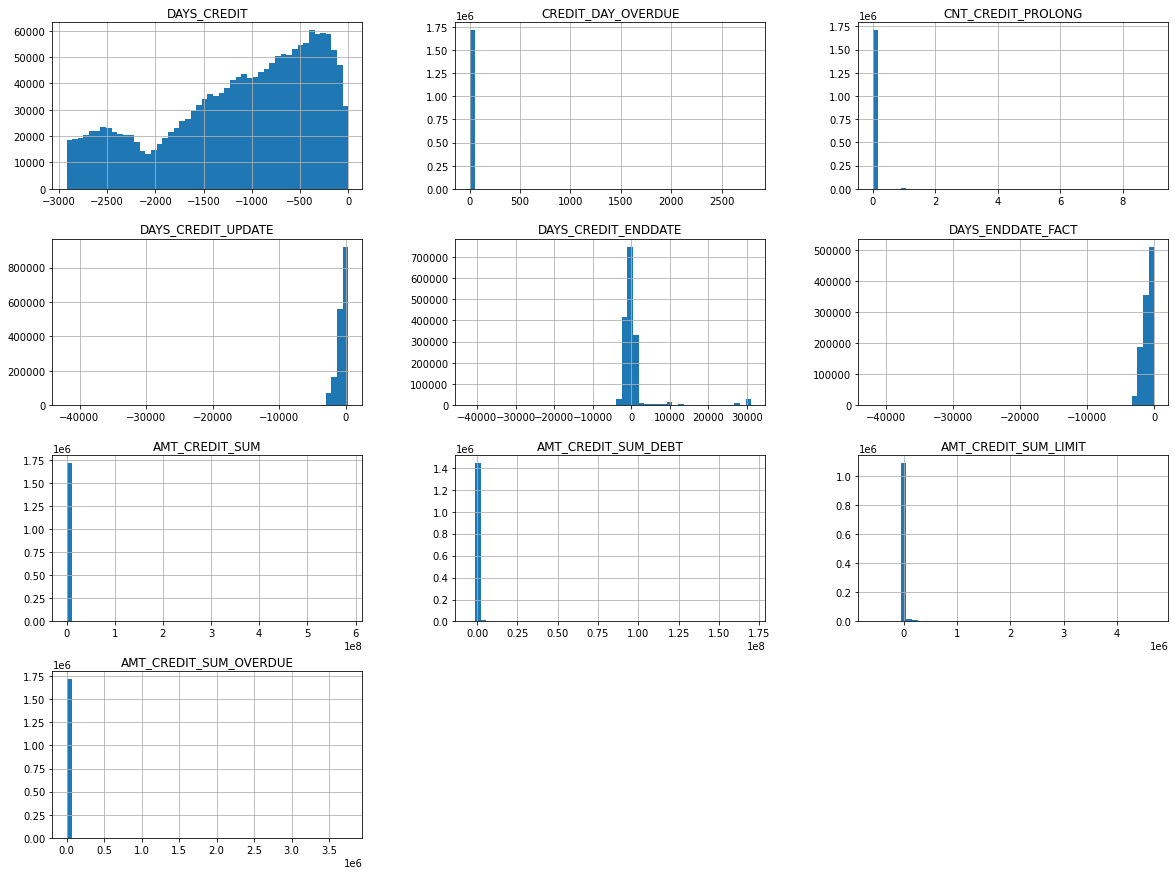

In [16]:
bureau[num_variables].hist(bins=50, figsize=(20,15))
plt.show()

Findings:

* "DAYS(...)" variables are counter-intuitively negative

In [17]:
#Put day variables in a list to be transformed together in the preprocessing pipeline, and exclude them from num_variables 
day_variables = [col for col in bureau.columns if 'DAYS' in col]
num_variables = [i for i in num_variables if i not in day_variables]

## Pipeline

In [18]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    
    def fit(self, bureau, y=None):
        return self
    
    def transform(self, bank):
        return bureau[self.attribute_names].values
    
    def get_feature_names(self):
        return self.attribute_names

In [19]:
def negative_to_positive(columns):
    for i in columns:
        bureau[i] = abs(bureau[i])

In [20]:
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_variables)),
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler())
        ])

day_col_pipeline = Pipeline([
        ('neg_to_pos', negative_to_positive(day_variables)),
        ('selector', DataFrameSelector(day_variables)),
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler())
        ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_variables)),
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('cat_encoder', OneHotEncoder())
        ])

preprocess_pipeline = ColumnTransformer([
        ("num_pipeline", num_pipeline, num_variables),
        ("days_pipeline", day_col_pipeline, day_variables),
        ("cat_pipeline", cat_pipeline, cat_variables)
])

In [21]:
preprocess_pipeline.fit(bureau)

preprocessed_bureau = preprocess_pipeline.transform(bureau)

In [22]:
num_feature_names = preprocess_pipeline.named_transformers_['num_pipeline'].named_steps['selector'].get_feature_names()
day_feature_names = preprocess_pipeline.named_transformers_['days_pipeline'].named_steps['selector'].get_feature_names()
cat_feature_names = list(preprocess_pipeline.named_transformers_['cat_pipeline'].named_steps['cat_encoder'].get_feature_names(cat_variables))
feature_names = num_feature_names + day_feature_names + cat_feature_names + cat_binary_variables

/Users/joaogoncalves/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [23]:
transformed_bureau_df = pd.DataFrame(preprocessed_bureau, columns=feature_names)
transformed_bureau_df = pd.concat([bureau[["SK_ID_CURR", "SK_ID_BUREAU"]],transformed_bureau_df], axis=1)
transformed_bureau_df

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_DAY_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,...,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan
0,215354,5714462,-0.022388,-0.06662,-0.229317,-0.185991,-0.111609,-0.006385,-0.811288,-0.353679,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,215354,5714463,-0.022388,-0.06662,-0.113056,0.087541,-0.111609,-0.006385,-1.174735,-0.150570,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,215354,5714464,-0.022388,-0.06662,0.095086,-0.185991,-0.111609,-0.006385,-1.181023,-0.271070,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,215354,5714465,-0.022388,-0.06662,-0.230467,-0.185991,-0.111609,-0.006385,-1.181023,-0.197492,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,215354,5714466,-0.022388,-0.06662,2.039479,-0.185991,-0.111609,-0.006385,-0.645285,-0.123694,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,-0.022388,-0.06662,-0.298957,-0.168032,-0.111609,-0.006385,-1.380981,-0.380775,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1716424,100044,5057754,-0.022388,-0.06662,-0.275578,-0.185991,-0.111609,-0.006385,1.893812,0.148587,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1716425,100044,5057762,-0.022388,-0.06662,-0.295200,-0.185991,-0.111609,-0.006385,0.838685,-0.028748,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1716426,246829,5057770,-0.022388,-0.06662,-0.277432,-0.185991,-0.111609,-0.006385,0.925459,-0.054082,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## GroupBy

In [25]:
grouped = transformed_bureau_df.groupby('SK_ID_CURR').agg(
    {'SK_ID_BUREAU': 'first',
    'CREDIT_DAY_OVERDUE': 'mean',
    'CNT_CREDIT_PROLONG': 'mean',
    'AMT_CREDIT_SUM': 'sum',
    'AMT_CREDIT_SUM_DEBT': 'sum',
    #FAZ SENTIDO O SUM LIMIT TER VALORES NEGATIVOS E N PORMOS A 0 ESSES? A CENA DA MEDIANA NA IMPUTATION AQUI É MEIO ESTRANHO POSSO SER SO EU
    'AMT_CREDIT_SUM_LIMIT': 'sum',
    'AMT_CREDIT_SUM_OVERDUE': 'mean',
    #NEGATIVOS??
    'DAYS_CREDIT': 'sum',
    #NEGATIVOS??
    'DAYS_CREDIT_ENDDATE': 'sum',
    #NEGATIVOS??
    'DAYS_ENDDATE_FACT': 'sum',
    #NEGATIVOS??
    'DAYS_CREDIT_UPDATE': 'sum',
    #SOMEI TODOS OS VALORES ONDE SE FAZIA O ENCODER
    'CREDIT_ACTIVE_Active': 'sum',
    'CREDIT_ACTIVE_Bad debt': 'sum',
    'CREDIT_ACTIVE_Closed': 'sum',
    'CREDIT_ACTIVE_Sold': 'sum',
    'CREDIT_CURRENCY_currency 1': 'sum',
    'CREDIT_CURRENCY_currency 2': 'sum',
    'CREDIT_CURRENCY_currency 3': 'sum',
    'CREDIT_CURRENCY_currency 4': 'sum',
    'CREDIT_TYPE_Another type of loan': 'sum',
    'CREDIT_TYPE_Car loan': 'sum',
    'CREDIT_TYPE_Cash loan (non-earmarked)': 'sum',
    'CREDIT_TYPE_Consumer credit': 'sum',
    'CREDIT_TYPE_Credit card': 'sum',
    'CREDIT_TYPE_Interbank credit': 'sum',
    'CREDIT_TYPE_Loan for business development': 'sum',
    'CREDIT_TYPE_Loan for purchase of shares (margin lending)': 'sum',
    'CREDIT_TYPE_Loan for the purchase of equipment': 'sum',
    'CREDIT_TYPE_Loan for working capital replenishment': 'sum',
    'CREDIT_TYPE_Microloan': 'sum',
    'CREDIT_TYPE_Mobile operator loan': 'sum',
    'CREDIT_TYPE_Mortgage': 'sum',
    'CREDIT_TYPE_Real estate loan': 'sum',
    'CREDIT_TYPE_Unknown type of loan': 'sum'
    })

grouped

,SK_ID_BUREAU,CREDIT_DAY_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,...,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,5896630,-0.022388,-0.066620,-0.897181,-0.349383,-0.781265,-0.006385,-3.583854,-1.476950,-1.434605,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100002,6158904,-0.022388,-0.066620,-1.717582,-1.095563,-0.018193,-0.006385,-2.697380,-1.849574,-3.165922,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100003,5885877,-0.022388,-0.066620,-0.350120,-0.743965,21.701851,-0.006385,1.301075,-0.533989,0.521159,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100004,6829133,-0.022388,-0.066620,-0.453074,-0.371983,-0.223219,-0.006385,-0.691951,-0.559543,-1.545333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100005,6735200,-0.022388,-0.066620,-0.354714,0.349439,-0.334828,-0.006385,-3.589600,-0.815412,-1.757543,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456249,5371696,-0.022388,-0.066620,-0.801046,-2.157559,-1.450921,-0.006385,8.582625,-0.987901,8.113571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
456250,6817236,-0.022388,-0.066620,1.758105,3.005276,1.258437,-0.006385,-1.056791,-0.190883,-0.640141,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
456253,6098498,-0.022388,-0.066620,2.209092,2.122920,-0.446437,-0.006385,-1.381388,-1.135827,-0.894451,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Bureau Balance

Monthly balances of previous credits in Credit Bureau.

In [24]:
bureau_balance = pd.read_csv('C:\\Users\\maria\\Desktop\\Uni\\S2\\Machine Learning\\Group Project\\data\\bureau_balance.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\maria\\Desktop\\Uni\\S2\\Machine Learning\\Group Project\\data\\bureau_balance.csv'

In [ ]:
bureau_balance.shape

(27299925, 3)

number of rows = # loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits

In [ ]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [ ]:
variables_type = pd.DataFrame(bureau_balance.dtypes)

cat_variables = list(variables_type[variables_type[0] == "object"].index)

int_variables = list(variables_type[variables_type[0] == "int64"].index)

float_variables = list(variables_type[variables_type[0] == "float64"].index)

cat_binary_variables = []
for i in bureau_balance:
    if ((list(bureau_balance[i].unique()) == [0,1]) or (list(bureau_balance[i].unique()) == [1,0])) and (i != "TARGET"):
        cat_binary_variables.append(i)

int_with_no_binary = [j for j in int_variables if j not in cat_binary_variables and j not in ["SK_ID_BUREAU"]]

num_variables = int_with_no_binary + float_variables

print("Categorical variables (non-binary coded):", cat_variables)
print("Categorical variables (binary):", cat_binary_variables)
print("Numerical variables:", num_variables)

Categorical variables (non-binary coded): ['STATUS']
Categorical variables (binary): []
Numerical variables: ['MONTHS_BALANCE']


In [ ]:
for column in cat_variables:
    print(column)
    print(bureau_balance[column].unique())
    print('--------------------------')

STATUS
['C' '0' 'X' '1' '2' '3' '5' '4']
--------------------------


**Duplicates**

In [ ]:
#check duplicates
duplicate_rows = bureau_balance[bureau_balance.duplicated()]
print('Number of duplicate rows:', len(duplicate_rows))

Number of duplicate rows: 0


**Missing Values**

In [ ]:
#List the variables with missing values higher or equal to 40% to exclude these variables later on
#List the variables with missing values higher than 0% and lower than 40% to preprocess them later on
miss_lower40 = []
miss_higher40 = []

for i in bureau_balance:
    pct_missing = (bureau_balance[i].isna().sum()/len(bureau_balance[i]))*100
    if pct_missing > 0 and pct_missing < 40:
        miss_lower40.append(i)
    if pct_missing >= 40:
        miss_higher40.append(i)

In [ ]:
#Exclude the variables with missing values higher or equal to 40%
if (len(miss_lower40) != 0) | (len(miss_higher40) != 0):
    cat_variables = [i for i in cat_variables if i not in miss_higher40]
    num_variables = [i for i in num_variables if i not in miss_higher40]

**Statistics**

In [ ]:
bureau_balance[num_variables].describe()

,MONTHS_BALANCE
count,2.729992e+07
mean,-3.074169e+01
std,2.386451e+01
min,-9.600000e+01
25%,-4.600000e+01
50%,-2.500000e+01
75%,-1.100000e+01
max,0.000000e+00


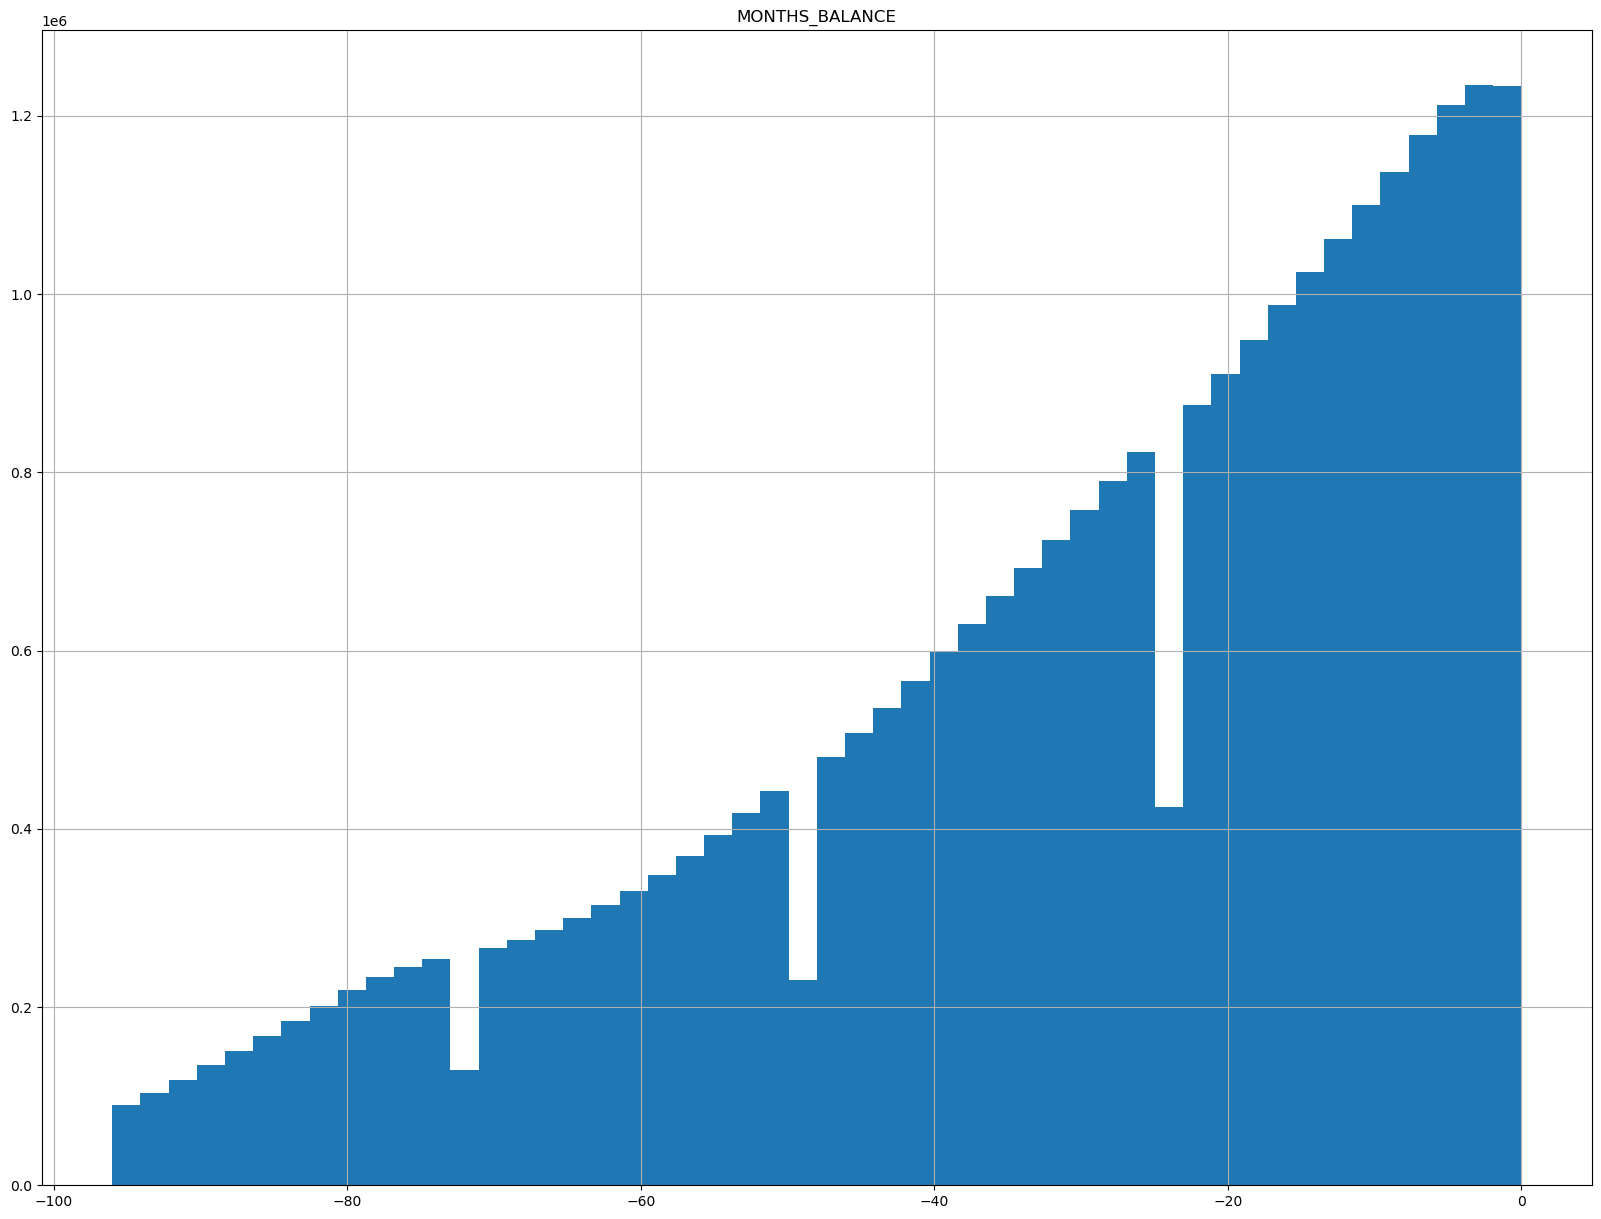

In [ ]:
bureau_balance[num_variables].hist(bins=50, figsize=(20,15))
plt.show()

Findings:

* MONTHS_BALANCE variable is counter-intuitively negative 

In [ ]:
#Put day variables in a list to be transformed together in the preprocessing pipeline, and exclude them from num_variables 
months_variables = [col for col in bureau_balance.columns if 'MONTHS' in col]
num_variables = [i for i in num_variables if i not in months_variables]

## Pipeline

In [ ]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    
    def fit(self, bureau_balance, y=None):
        return self
    
    def transform(self, bank):
        return bureau_balance[self.attribute_names].values
    
    def get_feature_names(self):
        return self.attribute_names

In [ ]:
def negative_to_positive(columns):
    for i in columns:
        bureau_balance[i] = abs(bureau_balance[i])

In [ ]:
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_variables)),
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler())
        ])

month_col_pipeline = Pipeline([
        ('neg_to_pos', negative_to_positive(months_variables)),
        ('selector', DataFrameSelector(months_variables)),
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler())
        ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_variables)),
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('cat_encoder', OneHotEncoder())
        ])

preprocess_pipeline = ColumnTransformer([
        ("num_pipeline", num_pipeline, num_variables),
        ("days_pipeline", month_col_pipeline, months_variables),
        ("cat_pipeline", cat_pipeline, cat_variables)
])

In [ ]:
preprocess_pipeline.fit(bureau_balance)

preprocessed_bureau_balance = preprocess_pipeline.transform(bureau_balance)

In [ ]:
num_feature_names = preprocess_pipeline.named_transformers_['num_pipeline'].named_steps['selector'].get_feature_names()
month_feature_names = preprocess_pipeline.named_transformers_['days_pipeline'].named_steps['selector'].get_feature_names()
cat_feature_names = list(preprocess_pipeline.named_transformers_['cat_pipeline'].named_steps['cat_encoder'].get_feature_names(cat_variables))
feature_names = num_feature_names + month_feature_names + cat_feature_names + cat_binary_variables

C:\Users\maria\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
transformed_bureau_balance_df = pd.DataFrame(preprocessed_bureau_balance, columns=feature_names)
transformed_bureau_balance_df = pd.concat([bureau_balance["SK_ID_BUREAU"],transformed_bureau_balance_df], axis=1)
transformed_bureau_balance_df

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\maria\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\maria\AppData\Local\Temp\ipykernel_14852\3149071050.py", line 1, in <module>
    transformed_bureau_balance_df = pd.DataFrame(preprocessed_bureau_balance, columns=feature_names)
  File "C:\Users\maria\Anaconda3\lib\site-packages\pandas\core\frame.py", line 710, in __init__
    data = list(data)
  File "C:\Users\maria\Anaconda3\lib\site-packages\scipy\sparse\_csr.py", line 244, in __iter__
    yield self.__class__(
  File "C:\Users\maria\Anaconda3\lib\site-packages\scipy\sparse\_compressed.py", line 90, in __init__
    self._shape = check_shape(shape)
  File "C:\Users\maria\Anaconda3\lib\site-packages\scipy\sparse\_sputils.py", line 291, in check_shape
    new_shape = tuple(operator.index(arg) for arg in args)
  File "C:\Users\maria\Anaconda3\lib\site-packages\scipy\sparse\_s

TypeError: object of type 'NoneType' has no len()

# POSH_CASH_balance

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.

In [ ]:
posh = pd.read_csv('C:\\Users\\maria\\Desktop\\Uni\\S2\\Machine Learning\\Group Project\\data\\POS_CASH_balance.csv')

In [ ]:
posh.shape

(10001358, 8)

In [ ]:
posh.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [ ]:
variables_type = pd.DataFrame(posh.dtypes)

cat_variables = list(variables_type[variables_type[0] == "object"].index)

int_variables = list(variables_type[variables_type[0] == "int64"].index)

float_variables = list(variables_type[variables_type[0] == "float64"].index)

cat_binary_variables = []
for i in posh:
    if ((list(posh[i].unique()) == [0,1]) or (list(posh[i].unique()) == [1,0])) and (i != "TARGET"):
        cat_binary_variables.append(i)

int_with_no_binary = [j for j in int_variables if j not in cat_binary_variables and j not in ["SK_ID_CURR", "SK_ID_PREV"]]

num_variables = int_with_no_binary + float_variables

print("Categorical variables (non-binary coded):", cat_variables)
print("Categorical variables (binary):", cat_binary_variables)
print("Numerical variables:", num_variables)

Categorical variables (non-binary coded): ['NAME_CONTRACT_STATUS']
Categorical variables (binary): []
Numerical variables: ['MONTHS_BALANCE', 'SK_DPD', 'SK_DPD_DEF', 'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE']


In [ ]:
for column in cat_variables:
    print(column)
    print(posh[column].unique())
    print('--------------------------')

NAME_CONTRACT_STATUS
['Active' 'Completed' 'Signed' 'Approved' 'Returned to the store' 'Demand'
 'Canceled' 'XNA' 'Amortized debt']
--------------------------


**Duplicates**

In [ ]:
#check duplicates
duplicate_rows = posh[posh.duplicated()]
print('Number of duplicate rows:', len(duplicate_rows))

Number of duplicate rows: 0


**Missing Values**

In [ ]:
#List the variables with missing values higher or equal to 40% to exclude these variables later on
#List the variables with missing values higher than 0% and lower than 40% to preprocess them later on
miss_lower40 = []
miss_higher40 = []

for i in posh:
    pct_missing = (posh[i].isna().sum()/len(posh[i]))*100
    if pct_missing > 0 and pct_missing < 40:
        miss_lower40.append(i)
    if pct_missing >= 40:
        miss_higher40.append(i)

In [ ]:
#Exclude the variables with missing values higher or equal to 40%
if (len(miss_lower40) != 0) | (len(miss_higher40) != 0):
    cat_variables = [i for i in cat_variables if i not in miss_higher40]
    num_variables = [i for i in num_variables if i not in miss_higher40]

**Statistics**

In [ ]:
posh[num_variables].describe()

,MONTHS_BALANCE,SK_DPD,SK_DPD_DEF,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE
count,1.000136e+07,1.000136e+07,1.000136e+07,9.975287e+06,9.975271e+06
mean,3.501259e+01,1.160693e+01,6.544684e-01,1.708965e+01,1.048384e+01
std,2.606657e+01,1.327140e+02,3.276249e+01,1.199506e+01,1.110906e+01
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,1.300000e+01,0.000000e+00,0.000000e+00,1.000000e+01,3.000000e+00
50%,2.800000e+01,0.000000e+00,0.000000e+00,1.200000e+01,7.000000e+00
75%,5.400000e+01,0.000000e+00,0.000000e+00,2.400000e+01,1.400000e+01
max,9.600000e+01,4.231000e+03,3.595000e+03,9.200000e+01,8.500000e+01


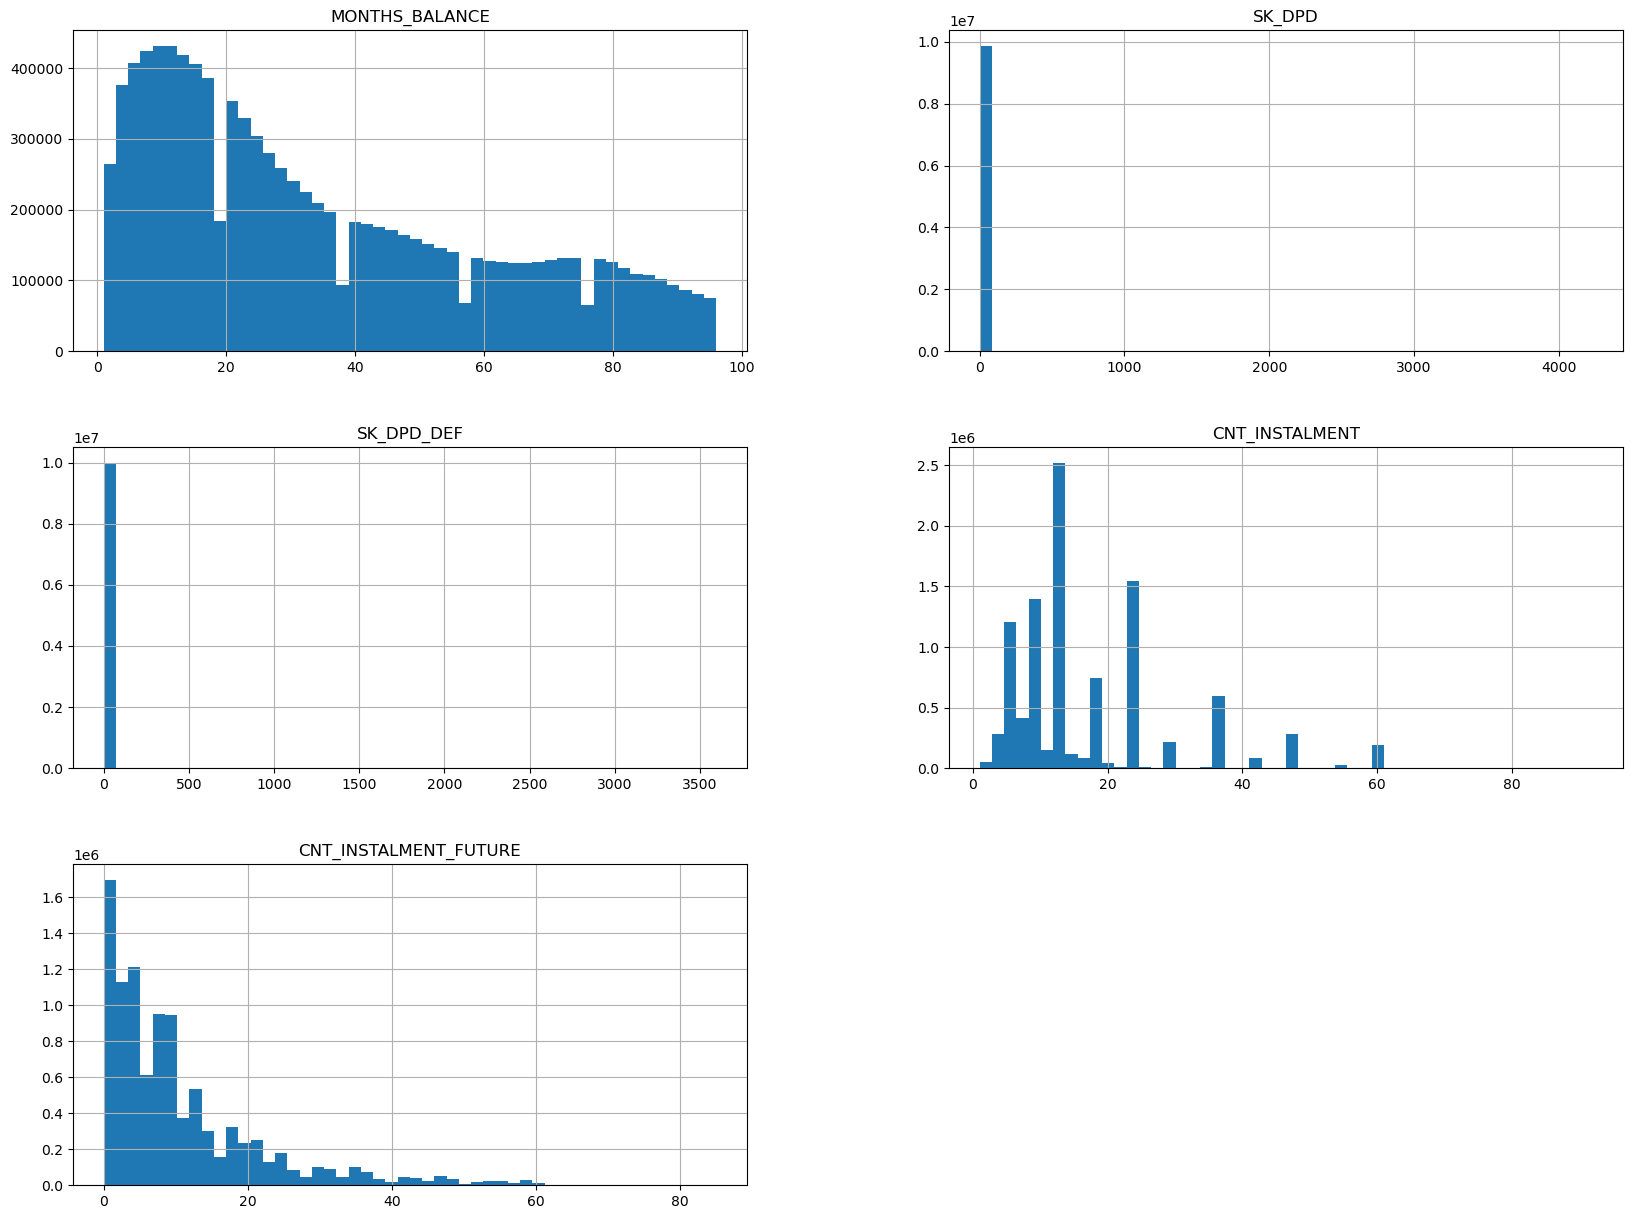

In [ ]:
posh[num_variables].hist(bins=50, figsize=(20,15))
plt.show()

Findings:

* MONTHS_BALANCE variable is counter-intuitively negative 

In [ ]:
#Put day variables in a list to be transformed together in the preprocessing pipeline, and exclude them from num_variables 
months_variables = [col for col in posh.columns if 'MONTHS' in col]
num_variables = [i for i in num_variables if i not in months_variables]

## Pipeline

In [ ]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    
    def fit(self, posh, y=None):
        return self
    
    def transform(self, bank):
        return posh[self.attribute_names].values
    
    def get_feature_names(self):
        return self.attribute_names

In [ ]:
def negative_to_positive(columns):
    for i in columns:
        posh[i] = abs(posh[i])

In [ ]:
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_variables)),
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler())
        ])

month_col_pipeline = Pipeline([
        ('neg_to_pos', negative_to_positive(months_variables)),
        ('selector', DataFrameSelector(months_variables)),
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler())
        ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_variables)),
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('cat_encoder', OneHotEncoder())
        ])

preprocess_pipeline = ColumnTransformer([
        ("num_pipeline", num_pipeline, num_variables),
        ("days_pipeline", month_col_pipeline, months_variables),
        ("cat_pipeline", cat_pipeline, cat_variables)
])

In [ ]:
preprocess_pipeline.fit(posh)

preprocessed_posh = preprocess_pipeline.transform(posh)

In [ ]:
num_feature_names = preprocess_pipeline.named_transformers_['num_pipeline'].named_steps['selector'].get_feature_names()
month_feature_names = preprocess_pipeline.named_transformers_['days_pipeline'].named_steps['selector'].get_feature_names()
cat_feature_names = list(preprocess_pipeline.named_transformers_['cat_pipeline'].named_steps['cat_encoder'].get_feature_names(cat_variables))
feature_names = num_feature_names + month_feature_names + cat_feature_names + cat_binary_variables

C:\Users\maria\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
transformed_posh_df = pd.DataFrame(preprocessed_posh, columns=feature_names)
transformed_posh_df = pd.concat([posh[["SK_ID_PREV", "SK_ID_CURR"]],transformed_posh_df], axis=1)
transformed_posh_df

,SK_ID_PREV,SK_ID_CURR,SK_DPD,SK_DPD_DEF,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,MONTHS_BALANCE,NAME_CONTRACT_STATUS_Active,NAME_CONTRACT_STATUS_Amortized debt,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Completed,NAME_CONTRACT_STATUS_Demand,NAME_CONTRACT_STATUS_Returned to the store,NAME_CONTRACT_STATUS_Signed,NAME_CONTRACT_STATUS_XNA
0,1803195,182943,-0.087458,-0.019976,2.580792,3.111509,-0.153936,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1715348,367990,-0.087458,-0.019976,1.579308,2.210282,-0.077210,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1784872,397406,-0.087458,-0.019976,-0.423660,-0.132909,-0.115573,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1903291,269225,-0.087458,-0.019976,2.580792,2.841141,-0.000483,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2341044,334279,-0.087458,-0.019976,1.579308,2.210282,-0.000483,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10001353,2448283,226558,6.264545,-0.019976,-0.924401,-0.944013,-0.575933,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10001354,1717234,141565,4.448611,-0.019976,-0.423660,-0.944013,-0.614296,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10001355,1283126,315695,4.501356,-0.019976,-0.590574,-0.944013,-0.537569,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10001356,1082516,450255,4.539031,-0.019976,-0.423660,-0.944013,-0.499206,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
